# Dog Breed Classifier v2

- Save the MobileNet v2 pretrained model for dog detection
- Try to replace the Google BiT model with MobileNet v2 since the model size of the Google BiT model is too big(~150MB) while MobileNet' is about 14MB 

## Import Libraries

In [40]:
!pip install torchsummary

In [41]:
!pip install torch-lr-finder

In [42]:
import torch
import torch.nn as nn
import torchvision.models as models
from PIL import Image
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader

from PIL import ImageFile
import os
from glob import glob
import numpy as np
from torchsummary import summary
from torch_lr_finder import LRFinder
from torch.optim.lr_scheduler import OneCycleLR

## Import Datasets

In [43]:
# load filenames for dog images
dog_files = np.array(glob("../dogImages/*/*/*"))

# print number of images
print('There are %d total dog images.' % len(dog_files))

There are 8351 total dog images.


## Data Preprocessing

In [50]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

## Data Splitting

In [51]:
train_dataset = datasets.ImageFolder('../dogImages/train', transform=preprocess)
valid_dataset = datasets.ImageFolder('../dogImages/valid', transform=preprocess)
test_dataset = datasets.ImageFolder('../dogImages/test', transform=preprocess)

BATCH_SIZE = 16

train_dataset_batch = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)
valid_dataset_batch = DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE,
)
test_dataset_batch = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
)

loaders_transfer = {
    'train': train_dataset_batch,
    'valid': valid_dataset_batch,
    'test': test_dataset_batch,
}

## Dog Detection

In [46]:
model_detection = models.mobilenet_v2(pretrained=True)

In [47]:
model_detection

MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=Tr

In [19]:
torch.save(model_detection, 'dog_detection_model.pt')

In [20]:
model_detection = torch.load('dog_detection_model.pt', map_location=torch.device('cpu'))

In [21]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

def imagenet_pretrained_model_predict(model, preprocess, img_path):
    '''
    Use a pre-trained model to obtain index corresponding to
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        index corresponding to pretrained model's prediction
    '''
    model.eval()
    input_img = Image.open(img_path)
    
    input_tensor = preprocess(input_img)
    input_batch = input_tensor.unsqueeze(0)
    
    with torch.no_grad():
        output = model(input_batch)
        
    return output.data.numpy().argmax()

In [22]:
def dog_detector(model, preprocess, img_path):
    result = imagenet_pretrained_model_predict(model, preprocess, img_path)
    return 151 <= result <= 268

In [23]:
SEED = 0
np.random.seed(SEED) # for reproducibility

num_choice = 500
choices = np.random.choice(len(dog_files), num_choice)

In [24]:
dog_files_dog_detector_results = [dog_detector(model_detection, preprocess, dog_files[choice]) for choice in choices]
print(f'What percentage in dog_files are successfully detected a dog face?: {sum(dog_files_dog_detector_results) / num_choice}')

What percentage in dog_files are successfully detected a dog face?: 0.984


## Dog Classification

### Model Training

In [52]:
model_transfer = models.mobilenet_v2(pretrained=True)

In [53]:
model_transfer

MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=Tr

In [54]:
# Replace the last fully-connected layer
for param in model_transfer.parameters():
    param.requires_grad = False
    # Parameters of newly constructed modules have requires_grad=True by default

model_transfer.classifier[0] = nn.Dropout(p=0.5, inplace=False)
model_transfer.classifier[1] = nn.Linear(1280, 133)

model_transfer

MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=Tr

In [55]:
# check if CUDA is available
use_cuda = torch.cuda.is_available()
print(use_cuda)

if use_cuda:
    model_transfer = model_transfer.cuda()

True


In [56]:
SEED = 0
np.random.seed(SEED) # for reproducibility

# https://pytorch.org/docs/stable/notes/randomness.html
# enable reproducibility in PyTorch
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [57]:
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = torch.optim.SGD(model_transfer.parameters(), lr=1e-7, momentum=0.9)

Stopping early, the loss has diverged

Learning rate search finished. See the graph with {finder_name}.plot()


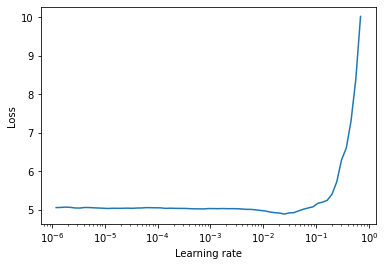

In [58]:
lr_finder = LRFinder(model_transfer, optimizer_transfer, criterion_transfer, device='cuda' if use_cuda else 'cpu')
lr_finder.range_test(loaders_transfer['train'], end_lr=100, num_iter=100)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

In [59]:
#from PIL import ImageFile
#ImageFile.LOAD_TRUNCATED_IMAGES = True
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf
    early_stopping_patience = 5
        
    scheduler = OneCycleLR(optimizer, max_lr=1e-3, steps_per_epoch=len(loaders['train']), epochs=n_epochs)
        
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()
            
            train_loss += ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            scheduler.step()
            if batch_idx + 1 == len(loaders['train']):
                print(scheduler.get_last_lr())
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            outputs = model(data)
            loss = criterion(outputs, target)
            valid_loss += ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            early_stopping_patience = 5
            print(f'Validation loss decreased ({valid_loss_min} --> {valid_loss}).  Saving model ...')
            torch.save(model, save_path)
            valid_loss_min = valid_loss
        else:
            early_stopping_patience -= 1
            if not early_stopping_patience:
                print(f'Early stopping...')
                break
    # return trained model
    return model

In [60]:
model_file = 'dog_classification_model_v2.pt'

In [61]:
n_epochs = 100
model_transfer = train(n_epochs, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, model_file)

[4.262990431259093e-05]
Epoch: 1 	Training Loss: 4.896869 	Validation Loss: 4.654789
Validation loss decreased (inf --> 4.654788970947266).  Saving model ...
[5.0490798930807944e-05]
Epoch: 2 	Training Loss: 4.614444 	Validation Loss: 4.357718
Validation loss decreased (4.654788970947266 --> 4.357717990875244).  Saving model ...
[6.34965446852456e-05]
Epoch: 3 	Training Loss: 4.341475 	Validation Loss: 4.022571
Validation loss decreased (4.357717990875244 --> 4.022570610046387).  Saving model ...
[8.150462546403715e-05]
Epoch: 4 	Training Loss: 4.023089 	Validation Loss: 3.671246
Validation loss decreased (4.022570610046387 --> 3.67124605178833).  Saving model ...
[0.0001043177098950924]
Epoch: 5 	Training Loss: 3.662005 	Validation Loss: 3.265269
Validation loss decreased (3.67124605178833 --> 3.265268564224243).  Saving model ...
[0.00013168581369037515]
Epoch: 6 	Training Loss: 3.315217 	Validation Loss: 2.851897
Validation loss decreased (3.265268564224243 --> 2.8518970012664795). 

### Model Testing

In [62]:
def test(loaders, model, criterion, use_cuda):
    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

In [63]:
model_test = torch.load(model_file, map_location=torch.device('cpu'))

In [64]:
criterion_transfer = nn.CrossEntropyLoss()
test(loaders_transfer, model_test, criterion_transfer, False)

Test Loss: 0.503747


Test Accuracy: 85% (716/836)
